In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "BBR-BPC"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:52171] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/1618149376/sm_segment.MacBook-Pro-de-Genereux.501.60730000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,930,XP_008221307.1,MDDSGHRENGRIKAEQYKAAQGQWLMQHQPSMKQIMAIMAERDAAL...,331,1
1,489,Gorai.001G243700.3,MDGAGQLENGRYKLDRYKGAHPPWNMMPQHHVKEQSNALVMNKKIM...,241,1
2,1105,Sobic.002G114400.1.p,MDDDDGSLGIRNWGFYDTVKGNLGLQLMSSAPPDRDTKSLLPNGAF...,350,1
3,2033,Aradu.60U13,MQKEKESITTNKEGTNKKEIEIMEGCNGKEETLPPGFRFHPTDEEL...,374,0
4,944,Prupe.8G082900.6.p,MDDGRQHENGRHKMDYYRGAASPWNMATQQQAKEPNALVMNKKIMS...,312,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1989 non-null   int64 
 1   id          1989 non-null   object
 2   sequence    1989 non-null   object
 3   length      1989 non-null   int64 
 4   class       1989 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 77.8+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AC,AD,AE,AF,AI,AK,AL,AR,AS,AT,...,YF,YG,YI,YK,YL,YP,YQ,YR,YS,YT
0,0.003012,0.003012,0.003012,0.003012,0.003012,0.003012,0.000000,0.003012,0.000000,0.000000,...,0.000000,0.003012,0.000000,0.000000,0.000000,0.003012,0.0,0.003012,0.000000,0.000000
1,0.000000,0.000000,0.004329,0.000000,0.008658,0.012987,0.000000,0.000000,0.012987,0.004329,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.000000,0.005865,0.011730,0.005865,0.017595,0.014663,0.002933,0.002933,0.002933,0.002933,...,0.000000,0.000000,0.002933,0.002933,0.000000,0.002933,0.0,0.005865,0.000000,0.000000
3,0.003623,0.000000,0.000000,0.007246,0.000000,0.003623,0.003623,0.000000,0.007246,0.000000,...,0.003623,0.000000,0.000000,0.000000,0.000000,0.007246,0.0,0.003623,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.002188,0.002188,0.006565,0.000000,0.010941,0.002188,...,0.000000,0.002188,0.000000,0.000000,0.008753,0.000000,0.0,0.000000,0.004376,0.002188


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1989, 200)
X_test: (498, 200)
y_train: (1989,)
y_test: (498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 19s 811ms/step - accuracy: 0.5625 - loss: 0.6929

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7680 - loss: 0.6738 - val_accuracy: 0.9573 - val_loss: 0.5030


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.5068

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.3569 - val_accuracy: 0.9925 - val_loss: 0.0501


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0371

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0369 - val_accuracy: 0.9925 - val_loss: 0.0395


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0151

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0224 - val_accuracy: 0.9899 - val_loss: 0.0429


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0022

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0249 - val_accuracy: 0.9899 - val_loss: 0.0406


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0526

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0202 - val_accuracy: 0.9874 - val_loss: 0.0460


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 0.9899 - val_loss: 0.0364


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0577

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0152 - val_accuracy: 0.9824 - val_loss: 0.0554


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0086

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0100 - val_accuracy: 0.9950 - val_loss: 0.0355


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.9759e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0087 - val_accuracy: 0.9925 - val_loss: 0.0369


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0047

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9899 - val_loss: 0.0400


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0024

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0025 - val_accuracy: 0.9799 - val_loss: 0.0608


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0045

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.9849 - val_loss: 0.0569


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0023

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9899 - val_loss: 0.0403


Epoch 15/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.6820e-04 - val_accuracy: 0.9925 - val_loss: 0.0413


Epoch 16/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.9179e-04 - val_accuracy: 0.9925 - val_loss: 0.0431


Epoch 17/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.5318e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9899 - val_loss: 0.0484


Epoch 18/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.3544e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.9826e-04 - val_accuracy: 0.9849 - val_loss: 0.0522


Epoch 19/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.3269e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9925 - val_loss: 0.0454



[Train Accuracy: 100.00% - Test Accuracy: 99.80%]


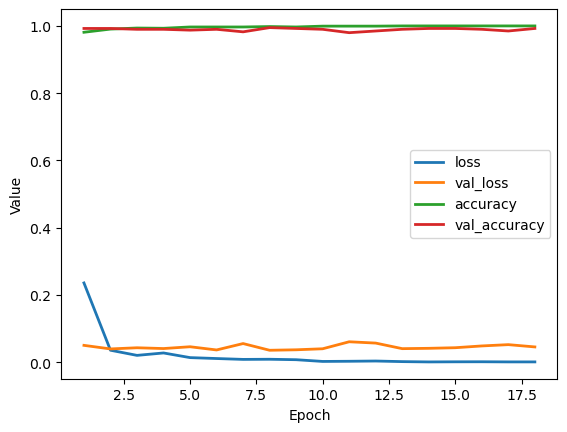

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,RKM,GWQ,GGW,CTG,HGT,CTT,CCT,WQS,GRK,PLP,...,RMG,SRK,RSC,KQP,IAT,PRH,PWL,CLE,NNN,ETT
0,0.003021,0.003021,0.003021,0.003021,0.003021,0.003021,0.003021,0.003021,0.003021,0.003021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002941
3,0.003636,0.003636,0.003636,0.003636,0.003636,0.000000,0.003636,0.003636,0.003636,0.003636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006579,0.000000


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1989, 1000)
X_test: (498, 1000)
y_train: (1989,)
y_test: (498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 16s 706ms/step - accuracy: 0.5312 - loss: 0.6933

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5309 - loss: 0.6866   

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5423 - loss: 0.6839 - val_accuracy: 0.8970 - val_loss: 0.5868


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7812 - loss: 0.6156

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.5184 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9002 - loss: 0.5065 - val_accuracy: 0.9874 - val_loss: 0.1846


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.1906

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.1269 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.1189 - val_accuracy: 1.0000 - val_loss: 0.0069


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0190

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0141 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.0027


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0018

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0042 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0018


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0016

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0024 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0017


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.8769e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0124     

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0011


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0017

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0041 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0040 - val_accuracy: 0.9975 - val_loss: 0.0056


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.9635e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0074     

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0013


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.3883e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0017     

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 3.8511e-04


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.8636e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.8526e-04 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9216e-04 - val_accuracy: 1.0000 - val_loss: 4.0662e-04


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.1243e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1839e-04 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8425e-04 - val_accuracy: 1.0000 - val_loss: 6.2088e-04


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.6237e-05

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5287e-04 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5330e-04 - val_accuracy: 1.0000 - val_loss: 9.0633e-04



[Train Accuracy: 100.00% - Test Accuracy: 99.80%]


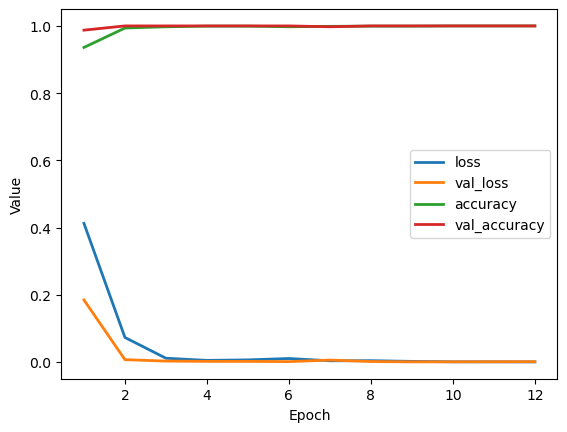

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAA,AAAV,AAEG,AAIA,AAIQ,AAIR,AALA,AALE,AALQ,AAQG,...,YNFS,YNWI,YPLP,YREN,YRGV,YRWG,YVRD,YWAK,YWAR,YYEP
0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00303,0.00000,0.0,0.00303,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00295,0.00295,0.0,0.0,0.0,0.00295,0.0,...,0.0,0.0,0.00295,0.00295,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00365,0.00000,0.0,0.00365,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 13s 559ms/step - accuracy: 0.4375 - loss: 0.6932

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4919 - loss: 0.6874   

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4953 - loss: 0.6863 - val_accuracy: 0.9925 - val_loss: 0.6013


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8750 - loss: 0.6147

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.5234 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9456 - loss: 0.5198 - val_accuracy: 0.9925 - val_loss: 0.2433


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.2571

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.1785 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.1765 - val_accuracy: 0.9925 - val_loss: 0.0448


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0413

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0387 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0385 - val_accuracy: 0.9925 - val_loss: 0.0300


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0119

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0167 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0167 - val_accuracy: 0.9925 - val_loss: 0.0292


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0040

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0147 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0146 - val_accuracy: 0.9925 - val_loss: 0.0230


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0084

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0120 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0120 - val_accuracy: 0.9925 - val_loss: 0.0307


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0063

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0058 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0062 - val_accuracy: 0.9925 - val_loss: 0.0203


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0067

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0072 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0070 - val_accuracy: 0.9925 - val_loss: 0.0309


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0056 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 0.9925 - val_loss: 0.0321


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0013

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0049 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0050 - val_accuracy: 0.9925 - val_loss: 0.0251



[Train Accuracy: 99.81% - Test Accuracy: 99.80%]


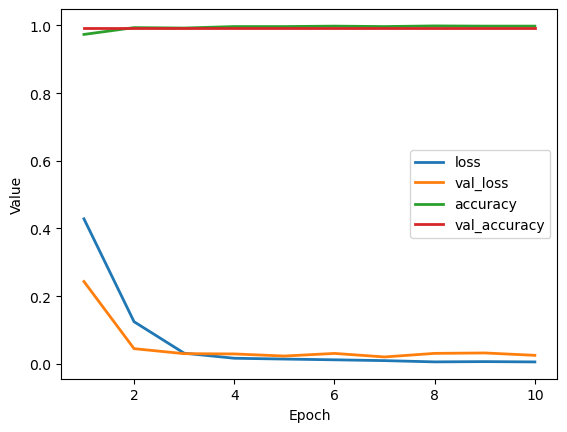

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAAA,AAEGH,AAEGY,AAIAE,AAIQE,AAIRE,AALAE,AALEL,AALQY,AAMAE,...,YRENS,YRWGA,YRWGC,YRWGS,YSTKD,YVRDS,YWAKH,YWARH,YYEPA,YYEPS
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.002959,0.002959,0.0,0.0,0.0,0.002959,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 15s 656ms/step - accuracy: 0.5156 - loss: 0.6933

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5139 - loss: 0.6891   

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5222 - loss: 0.6833 - val_accuracy: 0.5075 - val_loss: 0.5737


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5625 - loss: 0.5696

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.5101 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8897 - loss: 0.4833 - val_accuracy: 0.9849 - val_loss: 0.2416


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.2205

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.1912 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9919 - loss: 0.1745 - val_accuracy: 0.9824 - val_loss: 0.0455


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0224

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0421 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.0429 - val_accuracy: 0.9950 - val_loss: 0.0256


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0201

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0332 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9922 - loss: 0.0325 - val_accuracy: 0.9899 - val_loss: 0.0358


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0044

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0264 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9928 - loss: 0.0257 - val_accuracy: 0.9950 - val_loss: 0.0163


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0084

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0130 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - loss: 0.0139 - val_accuracy: 0.9950 - val_loss: 0.0187


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0034

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0092 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0108 - val_accuracy: 0.9950 - val_loss: 0.0130


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0061

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0169 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0167 - val_accuracy: 0.9950 - val_loss: 0.0138


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0063

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0116 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0112 - val_accuracy: 0.9950 - val_loss: 0.0115


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0080

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0083 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0088 - val_accuracy: 0.9950 - val_loss: 0.0093


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0057

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0046 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0060 - val_accuracy: 0.9950 - val_loss: 0.0108


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0041

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0107 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.0101 - val_accuracy: 0.9950 - val_loss: 0.0185


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.1116

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0286 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9956 - loss: 0.0213 - val_accuracy: 0.9950 - val_loss: 0.0110



[Train Accuracy: 99.75% - Test Accuracy: 99.80%]


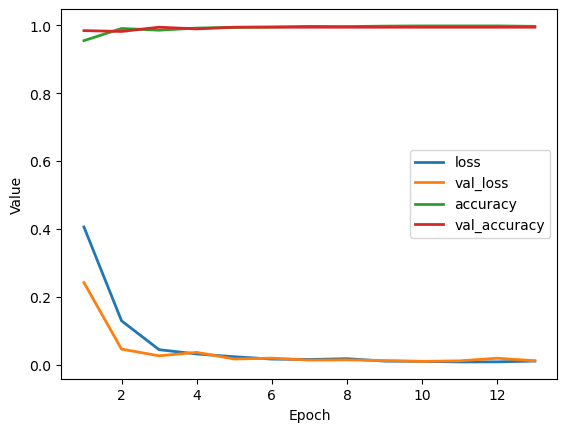

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


Report saved as Output/Reports/BBR-BPC/report_full_P3EMHE8S.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################